### Lab 5
- Juan Pablo Solis
- Brandon Reyes
- Carlos Valladares

### Task 1.1 Discretizacion Imagen

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

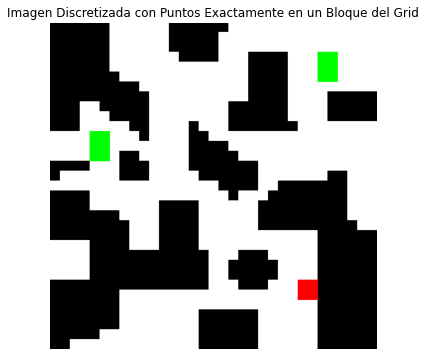

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen
image_path = "TEST.png"  # Cambiar por la ruta de la imagen
image = cv2.imread(image_path)

# Convertir a escala de grises
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Definir el tamaño del grid
grid_size = 20

# Obtener dimensiones originales
height, width = gray_image.shape

# --- Detectar los puntos de inicio (rojo) y metas (verde) ---
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Definir rangos de color para detectar rojo y verde
lower_red1, upper_red1 = np.array([0, 100, 100]), np.array([10, 255, 255])
lower_red2, upper_red2 = np.array([160, 100, 100]), np.array([180, 255, 255])
lower_green, upper_green = np.array([40, 50, 50]), np.array([90, 255, 255])

# Crear máscaras para rojo y verde
mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
mask_red = cv2.add(mask_red1, mask_red2)
mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

# Encontrar coordenadas de los puntos rojos y verdes
red_points = np.column_stack(np.where(mask_red > 0))
green_points = np.column_stack(np.where(mask_green > 0))

# Ajustar dimensiones del grid para evitar errores de índice
new_width = (width // grid_size) * grid_size
new_height = (height // grid_size) * grid_size

# Recortar la imagen para que sea múltiplo del grid_size
gray_image_cropped = gray_image[:new_height, :new_width]

# Crear la imagen reducida con la mediana de cada bloque
resized_image = np.zeros((new_height // grid_size, new_width // grid_size), dtype=np.uint8)

for i in range(0, new_height, grid_size):
    for j in range(0, new_width, grid_size):
        block = gray_image_cropped[i:i + grid_size, j:j + grid_size]
        resized_image[i // grid_size, j // grid_size] = np.median(block)

# Escalar de nuevo al tamaño original
discretized_image = cv2.resize(resized_image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

# Convertir a binario (blanco y negro)
_, binary_image = cv2.threshold(discretized_image, 127, 255, cv2.THRESH_BINARY)

# Convertir a color
color_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# Ajustar los puntos rojos y verdes para que ocupen exactamente un solo bloque del grid
for y, x in red_points:
    grid_x = (x // grid_size) * grid_size
    grid_y = (y // grid_size) * grid_size
    cv2.rectangle(color_image, (grid_x, grid_y),
                  (grid_x + grid_size, grid_y + grid_size), (0, 0, 255), -1)  # Rojo

for y, x in green_points:
    grid_x = (x // grid_size) * grid_size
    grid_y = (y // grid_size) * grid_size
    cv2.rectangle(color_image, (grid_x, grid_y),
                  (grid_x + grid_size, grid_y + grid_size), (0, 255, 0), -1)  # Verde

# Guardar la imagen ajustada
output_path_corrected = "discretized_corrected.png"
cv2.imwrite(output_path_corrected, color_image)

# Mostrar la imagen corregida
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
ax.set_title("Imagen Discretizada con Puntos Exactamente en un Bloque del Grid")
ax.axis("off")
plt.show()
